# Processing tilt-averaged 4D-STEM datasets

In [21]:
%matplotlib widget
import numpy as np
from ta4D_process import ta4D_datasets
import matplotlib.pyplot as plt
import py4DSTEM
import py4DSTEM.visualize.show as show
import tifffile

In [68]:
# Load data
data_path_common = 'e:/Tao/ta4D/12032025-ta4D-grating/ta4D-2deg-330kx-470mm'
N_scans = 12
data_path_list = [data_path_common + f'-{i+1}/scan_x256_y256.raw' for i in range(N_scans)]

empad_shapex = 256
empad_shapey = 256

# Load the datasets
scans = [py4DSTEM.import_file(data_path_list[i], mem='RAM', filetype='empad', EMPAD_shape=(empad_shapey,empad_shapex,130,128)) for i in range(N_scans)]
datasets = [scan.data for scan in scans]

# Filters out NaN in datasets
for i in range(N_scans):
    if np.isnan(datasets[i]).any():
        print(f'NaN detected in scan {i+1}! Replace NaN with 0...')
        datasets[i] = np.nan_to_num(datasets[i])
        

# Initialize ta4D_datasets object
ta4D_scans = ta4D_datasets(datasets)

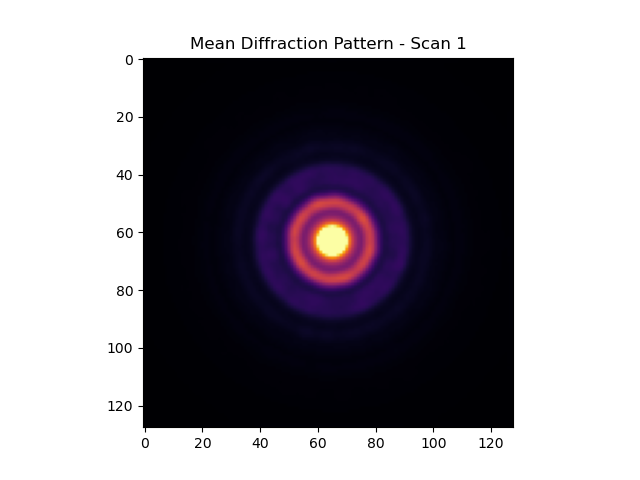

In [69]:
# Examine the first scan
dp_mean1 = ta4D_scans.get_mean_dp(ta4D_scans.datasets[0])
fig, ax = plt.subplots()
ax.imshow(dp_mean1, cmap='inferno', vmin=np.percentile(dp_mean1, 0.01), vmax=np.percentile(dp_mean1, 99.5))
ax.set_title('Mean Diffraction Pattern - Scan 1')
plt.show()


In [70]:
# Estimate the center of the BF disk
center = ta4D_scans.get_origin_single_dp(dp_mean1, center_guess=(64,64))

# Print the estimate probe radius
print(f'Estimated BF disk center: {center}')

Estimated BF disk center: (np.float64(65.0), np.float64(63.0))


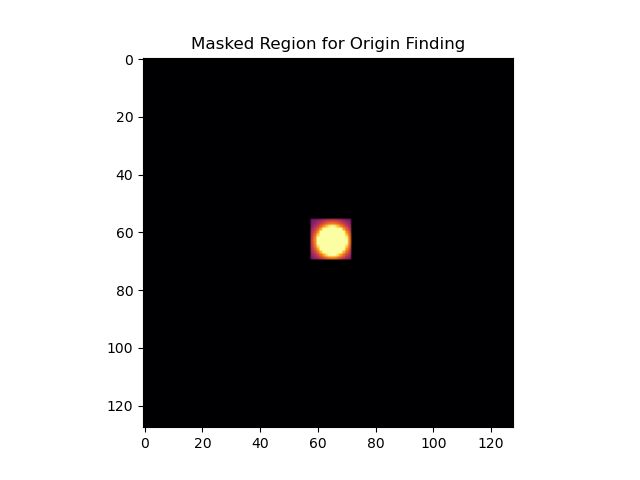

In [71]:
# Generate a mask region for origin finding
mask_region = np.zeros(dp_mean1.shape, dtype=bool)
bf_radius = 7
mask_region[round(center[1]-bf_radius):round(center[1]+bf_radius), round(center[0]-bf_radius):round(center[0]+bf_radius)] = True
fig, ax = plt.subplots()
ax.imshow(dp_mean1 * mask_region, cmap='inferno', vmin=np.percentile(dp_mean1, 0.01), vmax=np.percentile(dp_mean1, 99.5))
ax.set_title('Masked Region for Origin Finding')
plt.show()

Generating virtual images: 100%|██| 12/12 [00:07<00:00,  1.59it/s]


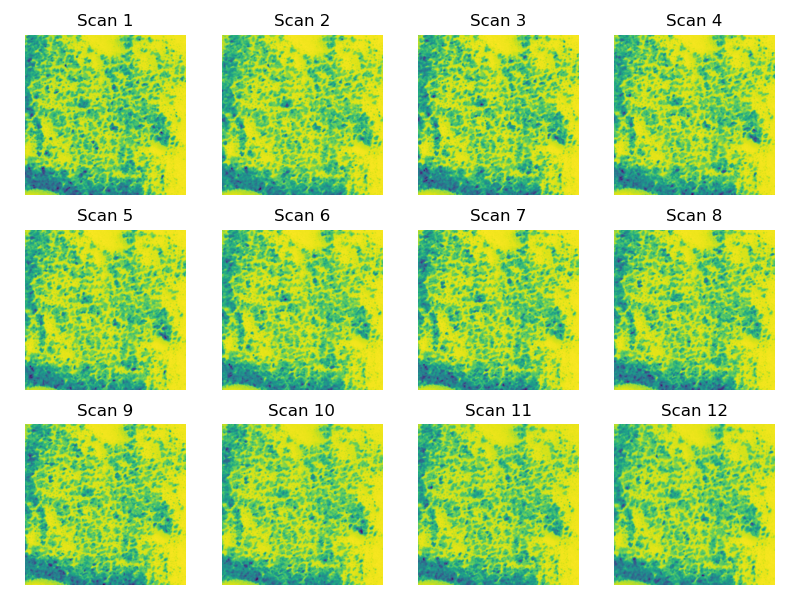

In [72]:
# Generate virtual brightfield images and plot
ta4D_scans.get_virtual_images_parallel(type='brightfield', center=center, radius=5)
ta4D_scans.plot_virtual_images()

Calculating mean diffraction patterns: 100%|█| 12/12 [00:04<00:00,


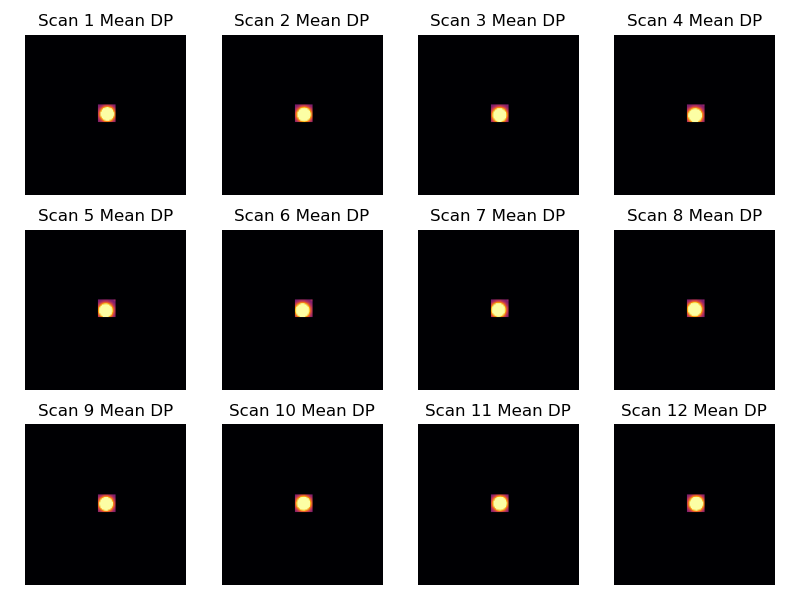

In [73]:
# Verify the mask works for all the scans
ta4D_scans.get_mean_dp_all_scans(mask=mask_region, pvmin=0.01, pvmax=99.5, cmap='inferno');

In [74]:
# All in one function to align the datasets
param = {
    'type': 'brightfield',
    'center': center,
    'radius': 7,
    'apply_hann_window': True,
    'refine_radius': bf_radius,
    'threshold': 1.2,
    'fit_plane': True,
    'upsampling': 1,
    'use_numba': True,
}
ta4D_scans.align_scans_dps(**param);

Finding image shifts: 100%|███████| 11/11 [00:00<00:00, 74.84it/s]


Shift of scan 2: (y, x) = (0, -9)
Shift of scan 3: (y, x) = (1, -7)
Shift of scan 4: (y, x) = (3, -6)
Shift of scan 5: (y, x) = (-1, -4)
Shift of scan 6: (y, x) = (2, -7)
Shift of scan 7: (y, x) = (1, -5)
Shift of scan 8: (y, x) = (2, -6)
Shift of scan 9: (y, x) = (2, -6)
Shift of scan 10: (y, x) = (0, -4)
Shift of scan 11: (y, x) = (-1, -2)
Shift of scan 12: (y, x) = (-2, -4)


Aligning scans: 100%|█████████████████████| 12/12 [00:00<?, ?it/s]


Scan 1 cropped from original indices of 3:254, 0:247, yielding a shape: (251, 247, 128, 128)
Scan 2 cropped from original indices of 3:254, 9:256, yielding a shape: (251, 247, 128, 128)
Scan 3 cropped from original indices of 2:253, 7:254, yielding a shape: (251, 247, 128, 128)
Scan 4 cropped from original indices of 0:251, 6:253, yielding a shape: (251, 247, 128, 128)
Scan 5 cropped from original indices of 4:255, 4:251, yielding a shape: (251, 247, 128, 128)
Scan 6 cropped from original indices of 1:252, 7:254, yielding a shape: (251, 247, 128, 128)
Scan 7 cropped from original indices of 2:253, 5:252, yielding a shape: (251, 247, 128, 128)
Scan 8 cropped from original indices of 1:252, 6:253, yielding a shape: (251, 247, 128, 128)
Scan 9 cropped from original indices of 1:252, 6:253, yielding a shape: (251, 247, 128, 128)
Scan 10 cropped from original indices of 3:254, 4:251, yielding a shape: (251, 247, 128, 128)
Scan 11 cropped from original indices of 4:255, 2:249, yielding a sha

Aligning DPs: 100%|███| 12/12 [01:49<00:00,  9.13s/it, scan=12/12]


In [38]:
ta4D_scans.aligned_datasets.shape

(251, 247, 128, 128)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


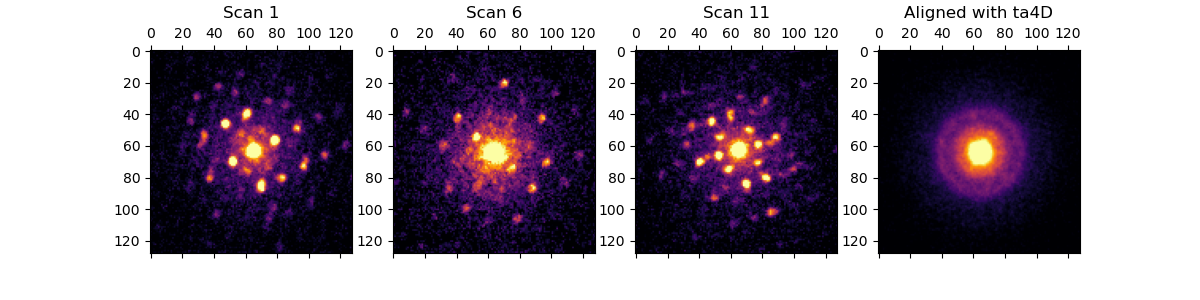

In [40]:
# Test on some random points to check the alignment quality
test_point = (91, 110)
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
show(ta4D_scans.datasets[0][test_point[0], test_point[1]], figax=(fig, ax[0]), cmap='inferno', title='Scan 1',
        intensity_range='ordered', vmin=0.3, vmax=0.99, power=0.5)
show(ta4D_scans.datasets[5][test_point[0], test_point[1]], figax=(fig, ax[1]), cmap='inferno', title='Scan 6',
        intensity_range='ordered', vmin=0.3, vmax=0.99, power=0.5)
show(ta4D_scans.datasets[10][test_point[0], test_point[1]], figax=(fig, ax[2]), cmap='inferno', title='Scan 11',
        intensity_range='ordered', vmin=0.3, vmax=0.99, power=0.5)
show(ta4D_scans.aligned_datasets[test_point[0], test_point[1]], figax=(fig, ax[3]), cmap='inferno', title='Aligned with ta4D',
        intensity_range='ordered', vmin=0.3, vmax=0.99, power=0.5)
plt.show()

In [75]:
# Save the aligned dataset
aligned_scan = scans[0].copy()
aligned_scan.data = ta4D_scans.aligned_datasets
py4DSTEM.save(data_path_common + '-12scans-aligned.h5', aligned_scan, mode='o')

In [76]:
# Align 3, 4, 6 scans
scans3 = [ta4D_scans.datasets_cropped[i] for i in range(0, ta4D_scans.N_scans, 4)]
scans3_origins = [ta4D_scans.fitted_dp_origins[i] for i in range(0, ta4D_scans.N_scans, 4)]
scans4 = [ta4D_scans.datasets_cropped[i] for i in range(0, ta4D_scans.N_scans, 3)]
scans4_origins = [ta4D_scans.fitted_dp_origins[i] for i in range(0, ta4D_scans.N_scans, 3)]
scans6 = [ta4D_scans.datasets_cropped[i] for i in range(0, ta4D_scans.N_scans, 2)]
scans6_origins = [ta4D_scans.fitted_dp_origins[i] for i in range(0, ta4D_scans.N_scans, 2)]

In [77]:
scans3_aligned = aligned_scan.copy()
scans3_aligned_data = np.zeros_like(scans3_aligned.data)
for i in range(len(scans3)):
    dp = scans3[i]
    origin = scans3_origins[i]
    scans3_aligned_data += ta4D_datasets.align_dps_single_scan_parallel((dp, origin))
scans3_aligned.data = scans3_aligned_data
py4DSTEM.save(data_path_common + '-3scans-aligned.h5', scans3_aligned, mode='o')

In [78]:
scans4_aligned = aligned_scan.copy()
scans4_aligned_data = np.zeros_like(scans4_aligned.data)
for i in range(len(scans4)):
    dp = scans4[i]
    origin = scans4_origins[i]
    scans4_aligned_data += ta4D_datasets.align_dps_single_scan_parallel((dp, origin))
scans4_aligned.data = scans4_aligned_data
py4DSTEM.save(data_path_common + '-4scans-aligned.h5', scans4_aligned, mode='o')

In [79]:
scans6_aligned = scans[0].copy()
scans6_aligned_data = np.zeros_like(ta4D_scans.datasets_cropped[0])
for i in range(len(scans6)):
    dp = scans6[i]
    origin = scans6_origins[i]
    scans6_aligned_data += ta4D_datasets.align_dps_single_scan_parallel((dp, origin))
scans6_aligned.data = scans6_aligned_data
py4DSTEM.save(data_path_common + '-6scans-aligned.h5', scans6_aligned, mode='o')